In [28]:
import pandas as pd
import numpy as np

from math import ceil
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('input/application_train.csv',index_col='SK_ID_CURR')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 286.2+ MB


In [3]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
(df.isnull().sum()/len(df)).sort_values(ascending=False)

COMMONAREA_MEDI                0.698723
COMMONAREA_AVG                 0.698723
COMMONAREA_MODE                0.698723
NONLIVINGAPARTMENTS_MODE       0.694330
NONLIVINGAPARTMENTS_MEDI       0.694330
NONLIVINGAPARTMENTS_AVG        0.694330
FONDKAPREMONT_MODE             0.683862
LIVINGAPARTMENTS_MEDI          0.683550
LIVINGAPARTMENTS_MODE          0.683550
LIVINGAPARTMENTS_AVG           0.683550
FLOORSMIN_AVG                  0.678486
FLOORSMIN_MEDI                 0.678486
FLOORSMIN_MODE                 0.678486
YEARS_BUILD_MEDI               0.664978
YEARS_BUILD_MODE               0.664978
YEARS_BUILD_AVG                0.664978
OWN_CAR_AGE                    0.659908
LANDAREA_AVG                   0.593767
LANDAREA_MEDI                  0.593767
LANDAREA_MODE                  0.593767
BASEMENTAREA_AVG               0.585160
BASEMENTAREA_MODE              0.585160
BASEMENTAREA_MEDI              0.585160
EXT_SOURCE_1                   0.563811
NONLIVINGAREA_MEDI             0.551792


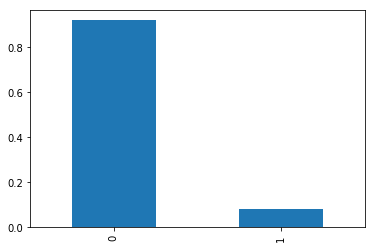

In [5]:
df.TARGET.value_counts(normalize=True).plot.bar()

In [6]:
df.groupby('CODE_GENDER').TARGET.mean()

CODE_GENDER
F      0.069993
M      0.101419
XNA    0.000000
Name: TARGET, dtype: float64

In [7]:
# extract names of numeric columns
dtypes = df.dtypes
cols_numeric = dtypes[dtypes != object].index.tolist()

# choose any numeric column with less than 13 values to be
# "discrete". 13 chosen to include months of the year.
# other columns "continuous"
col_nunique = dict()

for col in cols_numeric:
    col_nunique[col] = df[col].nunique()
    
col_nunique = pd.Series(col_nunique)

cols_discrete = col_nunique[col_nunique<13].index.tolist()
cols_continuous = col_nunique[col_nunique>=13].index.tolist()

print(len(cols_numeric),'numeric columns, of which',
      len(cols_continuous),'are continuous and',
      len(cols_discrete),'are discrete.')

105 numeric columns, of which 64 are continuous and 41 are discrete.


In [8]:
df[cols_discrete].nunique().sort_values(ascending=False)

AMT_REQ_CREDIT_BUREAU_QRT      11
DEF_30_CNT_SOCIAL_CIRCLE       10
AMT_REQ_CREDIT_BUREAU_DAY       9
AMT_REQ_CREDIT_BUREAU_WEEK      9
DEF_60_CNT_SOCIAL_CIRCLE        9
AMT_REQ_CREDIT_BUREAU_HOUR      5
REGION_RATING_CLIENT_W_CITY     3
REGION_RATING_CLIENT            3
FLAG_DOCUMENT_14                2
FLAG_DOCUMENT_19                2
FLAG_DOCUMENT_18                2
FLAG_DOCUMENT_17                2
FLAG_DOCUMENT_16                2
FLAG_DOCUMENT_15                2
FLAG_DOCUMENT_10                2
FLAG_DOCUMENT_13                2
FLAG_DOCUMENT_12                2
FLAG_DOCUMENT_11                2
FLAG_DOCUMENT_20                2
FLAG_CONT_MOBILE                2
FLAG_DOCUMENT_2                 2
TARGET                          2
FLAG_DOCUMENT_21                2
FLAG_MOBIL                      2
REG_REGION_NOT_LIVE_REGION      2
REG_CITY_NOT_WORK_CITY          2
REG_CITY_NOT_LIVE_CITY          2
LIVE_REGION_NOT_WORK_REGION     2
LIVE_CITY_NOT_WORK_CITY         2
FLAG_WORK_PHON

In [9]:
# extract names of categorical columns
cols_categ = dtypes[~dtypes.index.isin(cols_numeric)].index.tolist()

print(len(cols_categ),'categorical columns.')

16 categorical columns.


In [10]:
df[cols_categ].nunique().sort_values(ascending=False)

ORGANIZATION_TYPE             58
OCCUPATION_TYPE               18
NAME_INCOME_TYPE               8
WALLSMATERIAL_MODE             7
WEEKDAY_APPR_PROCESS_START     7
NAME_TYPE_SUITE                7
NAME_HOUSING_TYPE              6
NAME_FAMILY_STATUS             6
NAME_EDUCATION_TYPE            5
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
CODE_GENDER                    3
EMERGENCYSTATE_MODE            2
FLAG_OWN_REALTY                2
FLAG_OWN_CAR                   2
NAME_CONTRACT_TYPE             2
dtype: int64

In [11]:
df['CODE_GENDER'].replace('XNA',np.nan,inplace=True)

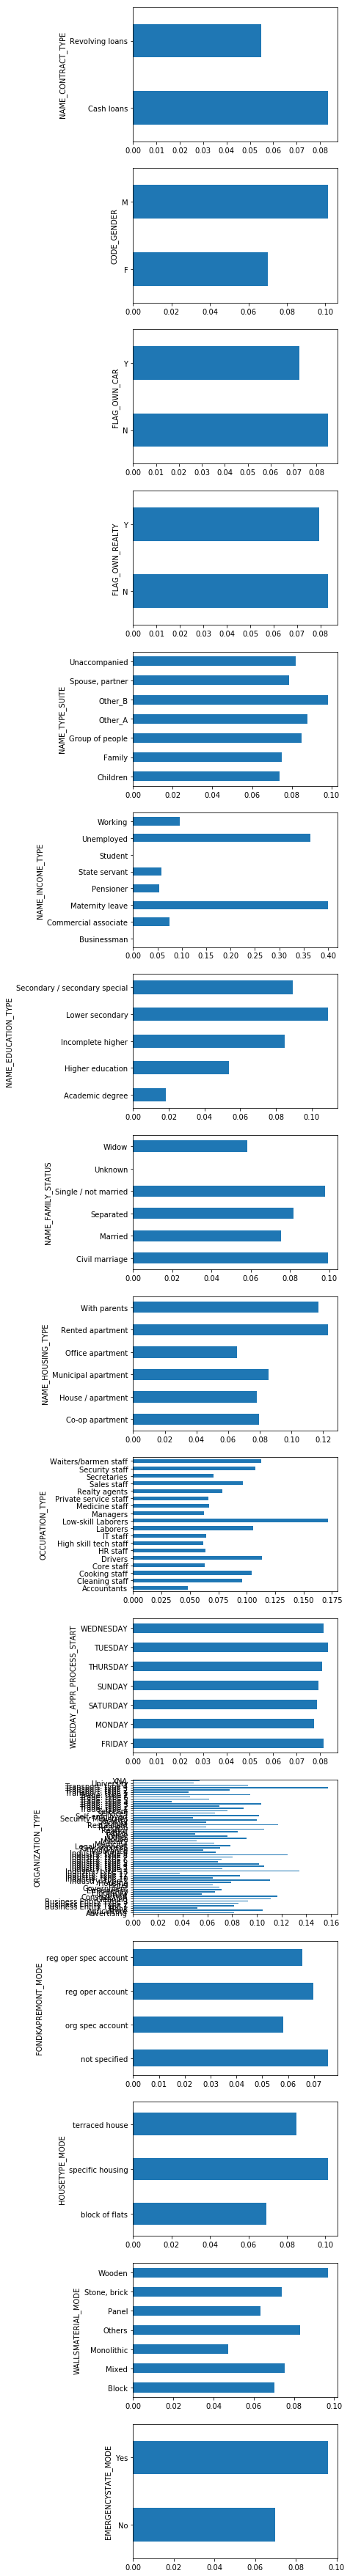

In [12]:
# plot categorical variables
fcols = 1
frows = ceil(len(cols_categ)/fcols)
plt.figure(figsize=(5,4*frows))

for i,col in enumerate(cols_categ):
    plt.subplot(frows,fcols,i+1)
    df.groupby(col).TARGET.mean().plot.barh()

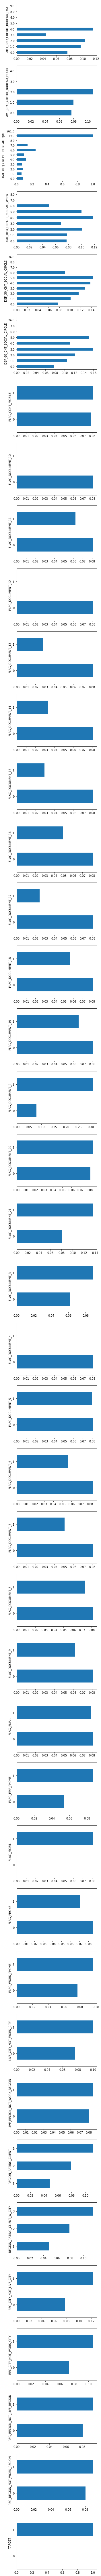

In [13]:
# plot discrete variables
fcols = 1
frows = ceil(len(cols_discrete)/fcols)
plt.figure(figsize=(5,4*frows))

for i,col in enumerate(cols_discrete):
    plt.subplot(frows,fcols,i+1)
    df.groupby(col).TARGET.mean().plot.barh()

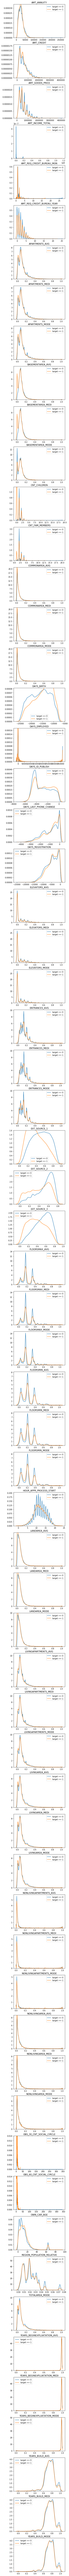

In [14]:
# plot continuous variables
fcols = 1
frows = ceil(len(cols_continuous)/fcols)
plt.figure(figsize=(5,4*frows))

for i,col in enumerate(cols_continuous):
    plt.subplot(frows,fcols,i+1)
    
    sns.kdeplot(df.loc[df['TARGET'] == 0, col].dropna(), label='target == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, col].dropna(), label='target == 1')
    plt.title(col)

In [15]:
def anova(col):
    tmp = [df.TARGET[col == val] for val in col[~col.isnull()].unique()]
    _,p = stats.f_oneway(*tmp)
    return p

In [16]:
df[cols_categ].apply(anova,axis=0).sort_values()

ORGANIZATION_TYPE             7.334467e-300
OCCUPATION_TYPE               3.866364e-289
NAME_INCOME_TYPE              5.444487e-267
NAME_EDUCATION_TYPE           1.058693e-219
CODE_GENDER                   1.788175e-202
NAME_FAMILY_STATUS            6.325710e-107
NAME_HOUSING_TYPE              9.556532e-89
NAME_CONTRACT_TYPE             7.868765e-66
FLAG_OWN_CAR                   8.424063e-34
WALLSMATERIAL_MODE             1.411737e-27
EMERGENCYSTATE_MODE            9.244778e-07
HOUSETYPE_MODE                 9.982585e-07
NAME_TYPE_SUITE                1.132318e-05
FLAG_OWN_REALTY                6.507605e-04
FONDKAPREMONT_MODE             7.729878e-04
WEEKDAY_APPR_PROCESS_START     1.744646e-02
dtype: float64

In [17]:
df[cols_discrete].apply(anova,axis=0).sort_values()

TARGET                          0.000000e+00
REGION_RATING_CLIENT_W_CITY    1.751582e-249
REGION_RATING_CLIENT           7.265561e-233
REG_CITY_NOT_WORK_CITY         3.805463e-176
FLAG_EMP_PHONE                 1.442660e-143
REG_CITY_NOT_LIVE_CITY         5.894986e-134
FLAG_DOCUMENT_3                1.153611e-133
LIVE_CITY_NOT_WORK_CITY         9.925670e-73
DEF_30_CNT_SOCIAL_CIRCLE        1.905695e-67
DEF_60_CNT_SOCIAL_CIRCLE        2.059383e-64
FLAG_DOCUMENT_6                 1.125274e-56
FLAG_WORK_PHONE                 2.231382e-56
FLAG_PHONE                      8.400751e-40
AMT_REQ_CREDIT_BUREAU_QRT       1.658169e-19
FLAG_DOCUMENT_16                1.187255e-10
FLAG_DOCUMENT_13                1.331659e-10
FLAG_DOCUMENT_14                1.536482e-07
FLAG_DOCUMENT_8                 8.244187e-06
FLAG_DOCUMENT_18                1.033985e-05
REG_REGION_NOT_WORK_REGION      1.183237e-04
FLAG_DOCUMENT_15                2.897606e-04
REG_REGION_NOT_LIVE_REGION      1.987609e-03
FLAG_DOCUM

In [30]:
def plot_roc_curve(y_true, y_pred, color='darkorange',plot_random=True):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    score = roc_auc_score(y_true, y_pred)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % score)
    
    if plot_random:
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

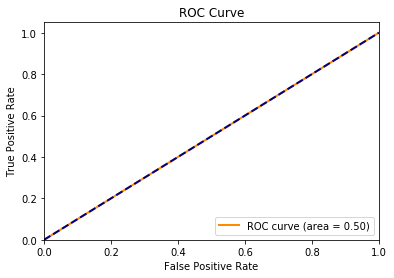

In [19]:
# predict constant
y = pd.DataFrame(df.TARGET)
y['PRED'] = y.TARGET.mean()
plot_roc_curve(y.TARGET, y.PRED)

In [20]:
for col in cols_categ:
    if df[col].dropna().nunique()==2:
        uniq = df[col].dropna().unique()
        print(col,uniq[0],uniq[1])
        df[col].replace({uniq[0]:0,uniq[1]:1},inplace=True)
    
df[cols_categ].head()

No     159428
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64
NAME_CONTRACT_TYPE Cash loans Revolving loans
CODE_GENDER M F
FLAG_OWN_CAR N Y
FLAG_OWN_REALTY Y N
EMERGENCYSTATE_MODE No Yes


0.0    159428
1.0      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

In [26]:
df = pd.get_dummies(df)
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,0,0.0,0,0,0,202500.000,406597.5,24700.5,351000.0,...,1,0,0,0,0,0,0,0,1,0
100003,0,0,1.0,0,1,0,270000.000,1293502.5,35698.5,1129500.0,...,1,0,0,1,0,0,0,0,0,0
100004,0,1,0.0,1,0,0,67500.000,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
100006,0,0,1.0,0,0,0,135000.000,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
100007,0,0,0.0,0,0,0,121500.000,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0
100008,0,0,0.0,0,0,0,99000.000,490495.5,27517.5,454500.0,...,0,0,0,0,0,0,0,0,0,0
100009,0,0,1.0,1,0,1,171000.000,1560726.0,41301.0,1395000.0,...,0,0,0,0,0,0,0,0,0,0
100010,0,0,0.0,1,0,0,360000.000,1530000.0,42075.0,1530000.0,...,0,0,0,0,0,0,0,0,0,0
100011,0,0,1.0,0,0,0,112500.000,1019610.0,33826.5,913500.0,...,0,0,0,0,0,0,0,0,0,0


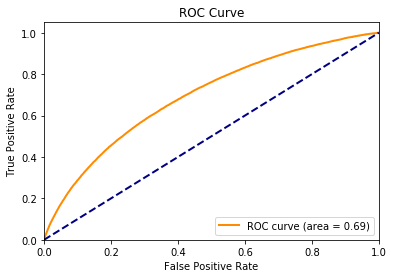

In [33]:
y_true = df.TARGET
X = df.drop('TARGET',axis=1)

pipe = Pipeline([('imputer', Imputer(strategy='median')), 
               ('scaler', MinMaxScaler(feature_range = (0, 1))),
               ('clf', LogisticRegression(C = 0.0001))])

pipe.fit(X,y_true)

y_pred = pipe.predict_proba(X)[:, 1]
plot_roc_curve(y_true, y_pred)